<a href="https://colab.research.google.com/github/Latamila/Scikit-learn_estudos_casos/blob/main/medical_charge_Aula1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastapi
!pip install kaleido
!pip install python-multipart
!pip install uvicorn
!pip install cohere
!pip install openai
!pip install tiktoken


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 467, in run
    env = get_environment(lib_locations)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/metadata/__init__.py", line 85, in get_environment
    return select_backend().Environment.from_paths(paths)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/metadata/pkg_resources.py", line 232, in from_paths
    return cls(pkg_resources.WorkingSet(paths))
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 613, in __init__
    self.add_entry(entry)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_res

In [1]:
#restart the kernel after installation
!pip install pandas-profiling --quiet

In [2]:
medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'

In [3]:
from urllib.request import urlretrieve

In [4]:
urlretrieve(medical_charges_url, 'medical.csv')

('medical.csv', <http.client.HTTPMessage at 0x7d8d92f71cf0>)

In [5]:
import pandas as pd

In [6]:
medical_df = pd.read_csv('medical.csv')

In [7]:
medical_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


O conjunto de dados contém 1.338 linhas e 7 colunas. Cada linha do conjunto de dados contém informações sobre um cliente.

Nosso objetivo é encontrar uma forma de estimar o valor da coluna “encargos” usando os valores das demais colunas. Se pudermos fazer isso com os dados históricos, também poderemos estimar as cobranças para novos clientes, simplesmente solicitando informações como idade, sexo, IMC, número. número de crianças, hábitos tabágicos e região.

Vamos verificar o tipo de dados de cada coluna.

In [8]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Parece que “idade”, “crianças”, “IMC” ( índice de massa corporal ) e “cargas” são números, enquanto “sexo”, “fumante” e “região” são strings (possivelmente categorias). Nenhuma das colunas contém valores ausentes, o que nos poupa bastante trabalho!

Aqui estão algumas estatísticas para as colunas numéricas:

In [9]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Os intervalos de valores nas colunas numéricas também parecem razoáveis ​​(sem idades negativas!), portanto, talvez não seja necessário fazer muita limpeza ou correção de dados. No entanto, a coluna "encargos" parece estar significativamente distorcida, uma vez que a mediana (percentil 50) é muito inferior ao valor máximo.

In [10]:
!pip install plotly matplotlib seaborn --quiet

In [11]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

As configurações a seguir melhorarão o estilo padrão e os tamanhos de fonte de nossos gráficos.

In [12]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

A idade é uma coluna numérica.

A idade `mínima no conjunto de dados é 18 anos e a idade máxima é 64 anos.`

 Assim, podemos visualizar a distribuição da idade usando um histograma com 47 bins (`um para cada ano`) e um box plot. Usaremos plotly para tornar o gráfico interativo, mas você pode criar gráficos semelhantes usando Seaborn.

In [13]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

In [14]:
fig = px.histogram(medical_df,
                   x='age',
                   marginal='box',
                   nbins=47,
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

A distribuição das idades no conjunto de dados é quase uniforme, com 20 a 30 clientes em todas as idades, exceto as idades de 18 e 19 anos, que parecem ter mais do dobro de clientes das outras idades. A distribuição uniforme pode surgir do facto de não haver uma grande variação no número de pessoas de qualquer idade (entre 18 e 64) nos EUA.

In [15]:
fig = px.histogram(medical_df,
                   x='bmi',
                   marginal='box',
                   color_discrete_sequence=['red'],
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

As medições do índice de massa corporal parecem `formar uma distribuição gaussiana centrada em torno do valor 30`, com alguns valores discrepantes à direita. Veja como os valores do IMC podem ser interpretados ( fonte ):

#Cobranças


Vamos visualizar a distribuição dos “encargos”, ou seja, os encargos médicos anuais dos clientes. Esta é a coluna que estamos tentando prever. Vamos também usar a coluna categórica `fumante` para distinguir as `cobranças para fumantes e não fumantes.`

In [16]:
fig = px.histogram(medical_df,
                   x='charges',
                   marginal='box',
                   color='smoker',
                   color_discrete_sequence=['green', 'grey'],
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

Podemos fazer as seguintes observações a partir do gráfico acima:

Para a maioria dos clientes, as despesas médicas anuais são inferiores a \$10.000. Apenas uma pequena fração dos clientes tem despesas médicas mais elevadas, possivelmente devido a acidentes, doenças graves e doenças genéticas. A distribuição segue uma "lei de potência"
Existe uma diferença significativa nas despesas médicas entre fumantes e não fumantes. Embora `a mediana para não fumantes seja
7300 ,a mediana dos fumantes está perto de 35.000.`

In [17]:
fig = px.histogram(medical_df,
                   x='charges',
                   marginal='box',
                   color='sex',
                   color_discrete_sequence=['orange', 'grey'],
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

In [18]:
fig = px.histogram(medical_df,
                   x='charges',
                   marginal='box',
                   color='region',
                   color_discrete_sequence=['green', 'grey','orange','blue'],
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

#Fumante


Vamos visualizar a distribuição da coluna “fumante” (contendo valores “sim” e “não”) por meio de um histograma.

In [19]:
medical_df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [20]:
px.histogram(medical_df, x='smoker', color='sex', title='Smoker')

`Parece que 20% dos clientes relataram que fumam.`

Pode verificar se isto corresponde à média nacional, assumindo que os dados foram recolhidos em 2010?

Podemos constatar também que fumar parece ser um hábito mais comum entre os homens. Você pode verificar isso?

Visualize as distribuições das colunas “sexo”, “região” e “crianças” e relate suas observações.

In [21]:
px.histogram(medical_df, x='sex', color='smoker', title='Smoker')

In [22]:
px.histogram(medical_df, x='region', color='smoker', title='Smoker')


In [23]:
px.histogram(medical_df, x='children', color='smoker', title='Smoker')

Idade e encargos
Vamos visualizar a relação entre “idade” e “cargas” usando um gráfico de dispersão. Cada ponto no gráfico de dispersão representa um cliente. Também usaremos valores na coluna “fumante” para colorir os pontos.

In [24]:
fig = px.scatter(medical_df,
                 x='age',
                 y='charges',
                 color='smoker',
                 opacity=0.8,
                 hover_data=['sex'],
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

Podemos fazer as seguintes observações a partir do gráfico acima:

A tendência geral parece ser que as despesas médicas aumentem com a idade, como seria de esperar. `No entanto, há uma variação significativa em cada idade e está claro que a idade por si só não pode ser usada para determinar com precisão as despesas médicas.`

Podemos ver `três "aglomerados" de pontos`, cada um dos quais parece formar uma linha com inclinação crescente:


DE BAIXO PARA CIMA

`O primeiro e maior grupo consiste principalmente em presumivelmente "não fumantes saudáveis"` que têm despesas médicas relativamente baixas em comparação com outros.

`O segundo grupo contém uma mistura de fumadores e não fumadores`. É possível que estes sejam, na verdade, dois grupos distintos, mas sobrepostos: “não fumantes com problemas médicos” e “fumantes sem problemas médicos graves”.

`O grupo final consiste exclusivamente de fumantes`, presumivelmente fumantes com problemas médicos graves que podem estar relacionados ou agravados pelo tabagismo.

#IMC e encargos


Vamos visualizar a relação entre o IMC (índice de massa corporal) e as cargas usando outro gráfico de dispersão. Mais uma vez, usaremos os valores da coluna “fumante” para colorir os pontos.

In [25]:
fig = px.scatter(medical_df,
                 x='bmi',
                 y='charges',
                 color='smoker',
                 opacity=0.8,
                 hover_data=['sex'],
                 title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

`Parece que para os não fumadores, um aumento no IMC não parece estar relacionado com um aumento nas despesas médicas`. No entanto, os custos médicos parecem ser significativamente mais elevados para fumadores com IMC superior a 30.

In [26]:
fig = px.violin(medical_df,
                 x='sex',
                 y='charges',
                 color='smoker',
                 hover_data=['sex'],
                 title='Sex vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

In [27]:
fig = px.violin(medical_df,
                 x='region',
                 y='charges',
                 color='smoker',
                 hover_data=['sex'],
                 title='Region vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

AttributeError: 'Axes' object has no attribute 'show'

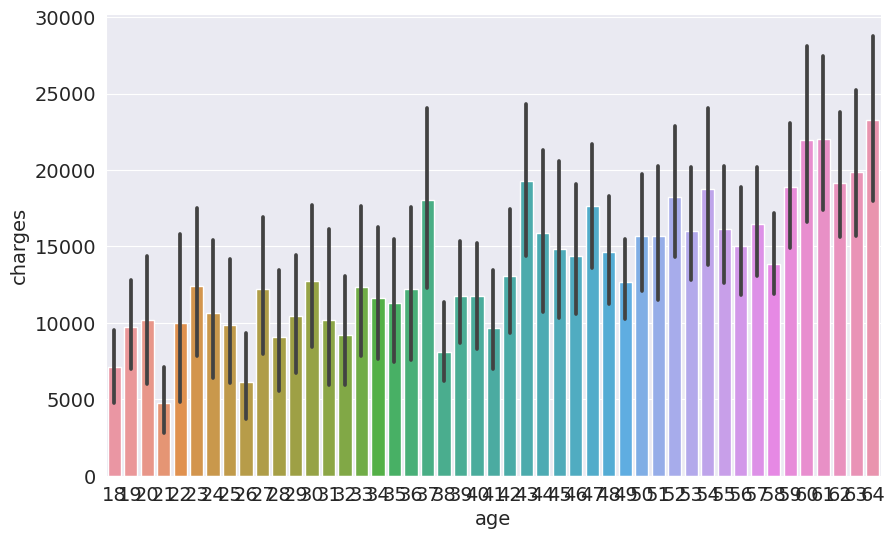

In [28]:
fig = sns.barplot(medical_df,
                   x='age',
                 y='charges')

fig.show()

Como você pode perceber pela análise, `os valores em algumas colunas estão mais intimamente relacionados aos valores em “encargos”` em comparação com outras colunas. Por exemplo, “idade” e “cargas” parecem crescer juntas, enquanto “IMC” e “cargas” não.

`Esta relação é frequentemente expressa numericamente usando uma medida chamada coeficiente de correlação , que pode ser calculado usando o .corr método de uma série Pandas.`

In [29]:
medical_df.charges.corr(medical_df.age)

0.2990081933306476

In [30]:
medical_df.charges.corr(medical_df.bmi)

0.19834096883362895

Para calcular a correlação para colunas categóricas, elas devem primeiro ser convertidas em colunas numéricas.

In [31]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_values)
medical_df.charges.corr(smoker_numeric)

0.787251430498478

Veja como os coeficientes de correlação podem ser interpretados ( source ):

`Força` : Quanto maior o valor absoluto do coeficiente de correlação, mais forte é a relação.

Os valores extremos de -1 e 1 indicam uma relação perfeitamente linear onde uma mudança numa variável é acompanhada por uma mudança perfeitamente consistente na outra. Para esses relacionamentos, todos os pontos de dados ficam em uma linha. Na prática, você não verá nenhum dos dois tipos de relacionamento perfeito.

`Um coeficiente de zero não representa nenhuma relação linear. À medida que uma variável aumenta, não há tendência na outra variável de aumentar ou diminuir.`


Quando o valor está entre 0 e +1/-1, há uma relação, mas nem todos os pontos caem em uma linha. À medida que r se aproxima de -1 ou 1, a força do relacionamento aumenta e os pontos de dados tendem a ficar mais próximos de uma linha.

`Direção` : O sinal do coeficiente de correlação representa a direção do relacionamento.

`Coeficientes positivos` indicam que quando o valor de uma variável aumenta, o valor da outra variável também tende a aumentar. Relacionamentos positivos produzem uma inclinação ascendente em um gráfico de dispersão.

`Os coeficientes negativos` representam casos em que o valor de uma variável aumenta, o valor da outra variável tende a diminuir. Relacionamentos negativos produzem uma inclinação descendente.

Os dataframes do Pandas também fornecem um .corrmétodo para calcular os coeficientes de correlação entre todos os pares de colunas numéricas.


In [32]:
medical_df.corr()

<ipython-input-32-cf93875bab50>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


<ipython-input-33-32f619adbb17>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



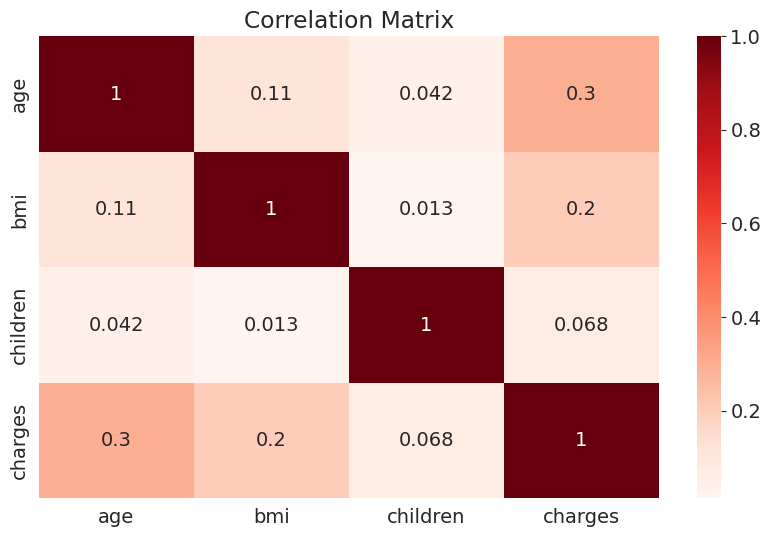

In [33]:
sns.heatmap(medical_df.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix');

os computadores não conseguem diferenciar entre correlação e causalidade, e as decisões baseadas em sistemas automatizados podem muitas vezes ter consequências importantes na sociedade, por isso é importante estudar porque é que os sistemas automatizados levam a um determinado resultado. Determinar relações de causa-efeito requer visão humana.

#Regressão linear usando um único recurso


`Sabemos agora que as colunas “fumante” e “idade” têm a correlação mais forte com “acusações”.` Vamos tentar encontrar uma `forma de estimar o valor dos “encargos” utilizando o valor da “idade” para não fumadores`. Primeiro, vamos criar um quadro de dados contendo apenas os dados de não fumantes.

In [34]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

A seguir, vamos visualizar a relação entre “idade” e “cargas”

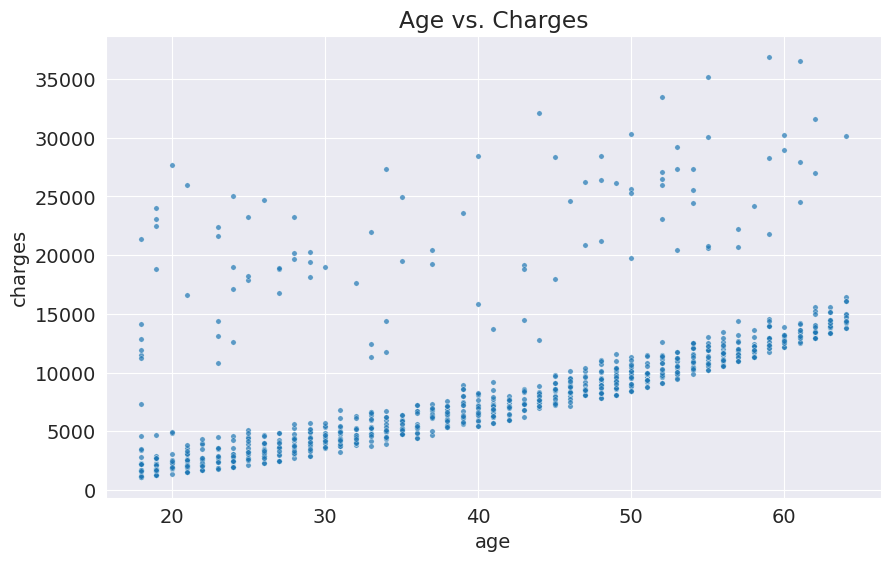

In [35]:
plt.title('Age vs. Charges')
sns.scatterplot(data=non_smoker_df, x='age', y='charges', alpha=0.7, s=15);

Salvo algumas exceções, os pontos parecem formar uma linha. Tentaremos "encaixar" uma linha usando esses pontos e usaremos a linha para prever cobranças para uma determinada idade. Uma linha nas coordenadas X e Y tem a seguinte fórmula

In [36]:
def estimate_charges(age, w, b):
    return w * age + b

A estimate_chargesfunção é nosso primeiro modelo .

Vamos adivinhar os valores para
w e b. use-os para estimar o valor das cobranças.

In [37]:
w = 50
b = 100

In [38]:
ages = non_smoker_df.age
estimated_charges = estimate_charges(ages, w, b)

Podemos traçar os encargos estimados usando um gráfico de linhas.

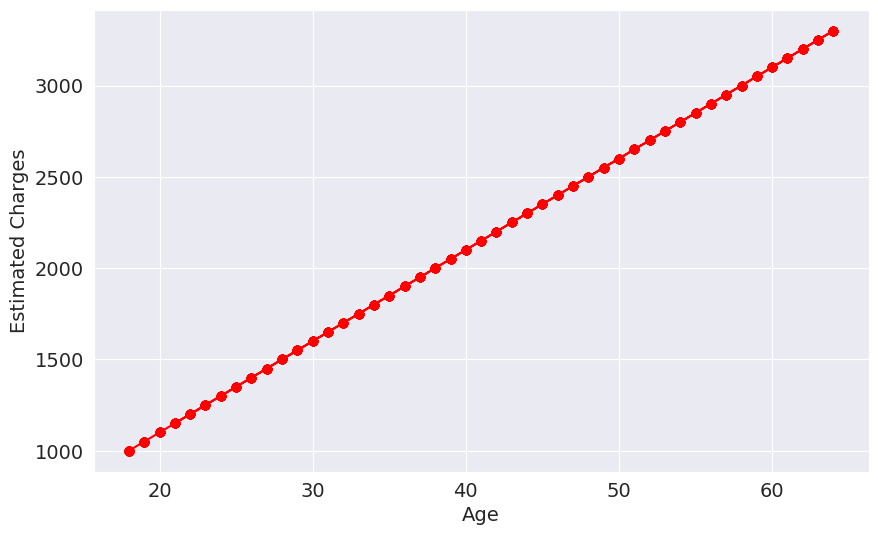

In [39]:
plt.plot(ages, estimated_charges, 'r-o');
plt.xlabel('Age');
plt.ylabel('Estimated Charges');

Como esperado, os pontos estão em linha reta.

Podemos sobrepor esta linha aos dados reais, para ver quão bem nosso modelo se ajusta aos dados .

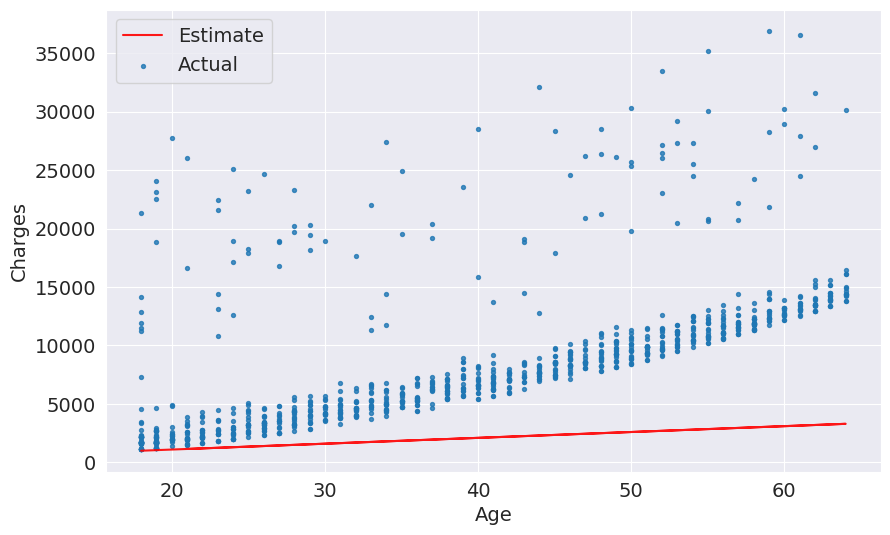

In [40]:
target = non_smoker_df.charges

plt.plot(ages, estimated_charges, 'r', alpha=0.9);
plt.scatter(ages, target, s=8,alpha=0.8);
plt.xlabel('Age');
plt.ylabel('Charges')
plt.legend(['Estimate', 'Actual']);

Claramente, as nossas estimativas são bastante fracas e a linha não “se ajusta” aos dados

Vamos definir uma função auxiliar try_parametersque recebe we bcomo entradas e cria o gráfico acima.

In [41]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges

    estimated_charges = estimate_charges(ages, w, b)

    plt.plot(ages, estimated_charges, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Estimate', 'Actual']);

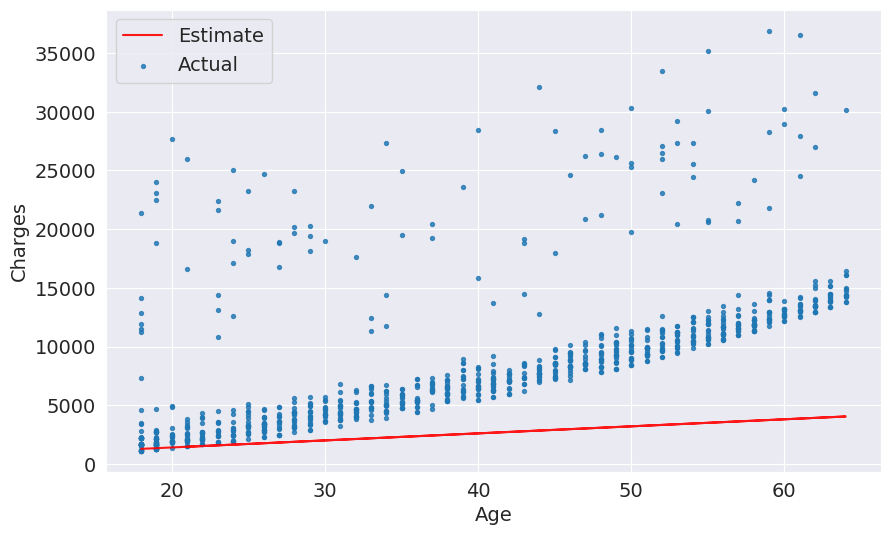

In [42]:
try_parameters(60, 200)

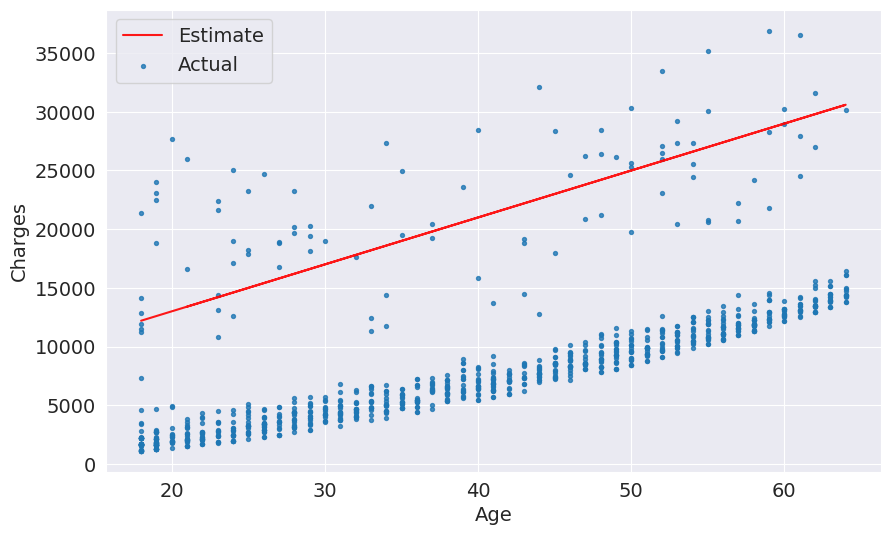

In [43]:
try_parameters(400, 5000)

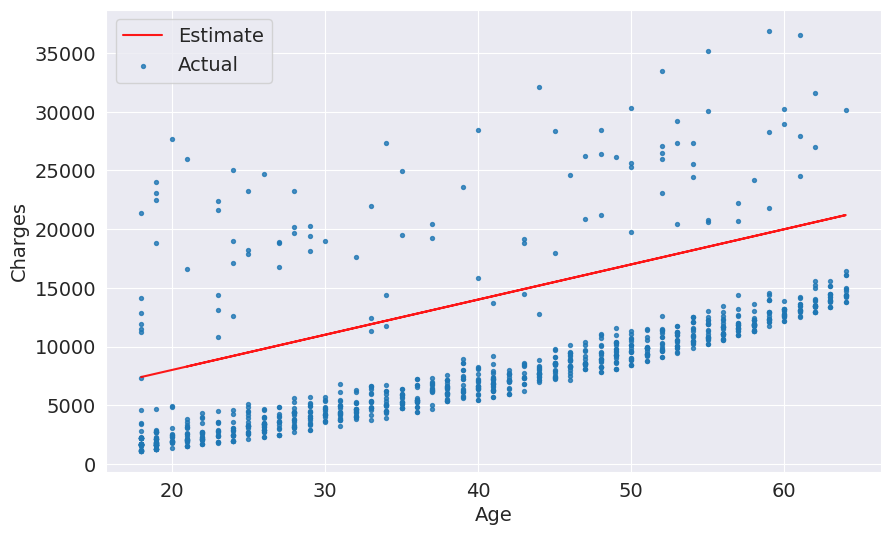

In [44]:
try_parameters(300, 2000)

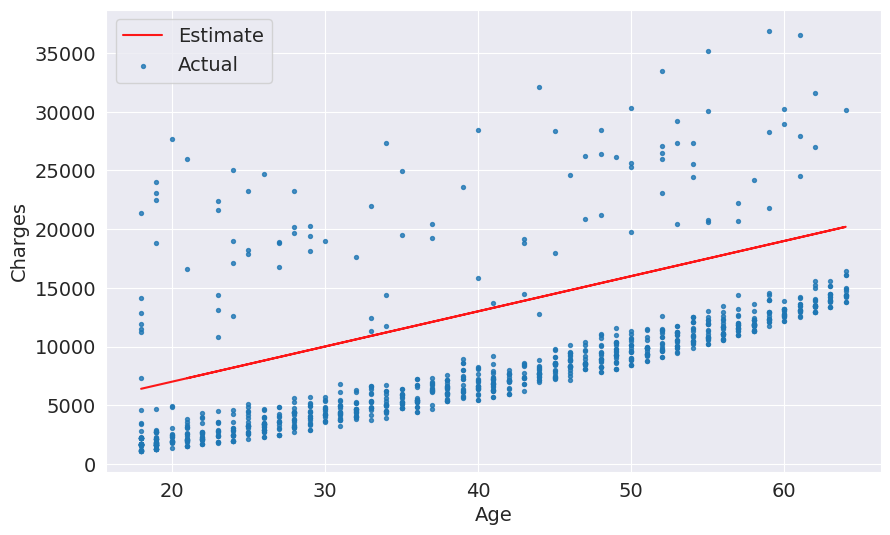

In [45]:
try_parameters(300, 1000)

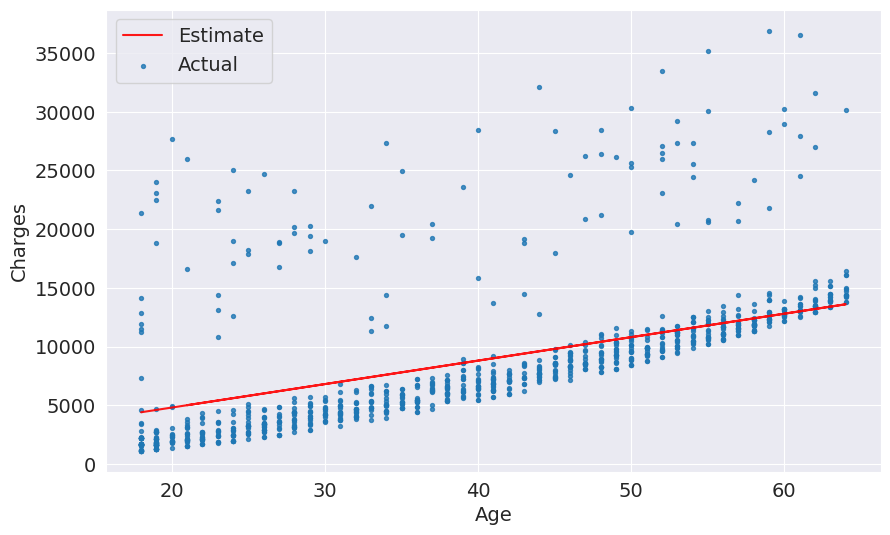

In [46]:
try_parameters(200, 800)

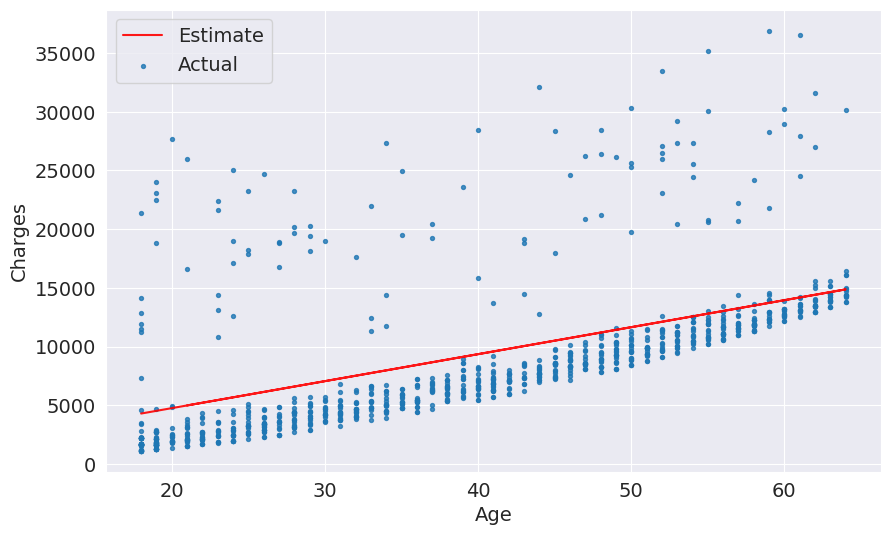

In [47]:
try_parameters(230,150)


À medida que alteramos os valores, de
Em
Eme
�
bmanualmente, tentando aproximar visualmente a linha dos pontos, vamos aprendendo a relação aproximada entre “idade” e “cargas”.

Não seria bom se um computador pudesse testar vários valores diferentes de we be aprender a relação entre “idade” e “cargas”? Para fazer isso, precisamos resolver alguns problemas:

Precisamos de uma maneira de medir numericamente quão bem a reta se ajusta aos pontos.

Uma vez calculada a "medida de ajuste", precisamos de uma forma de modificar we bmelhorar o ajuste.

Se pudermos resolver os problemas acima, deverá ser possível para um computador determinar wa blinha de melhor ajuste, começando com uma estimativa aleatória

#Função Perda/Custo

Podemos comparar as previsões do nosso modelo com os alvos reais usando o seguinte método:

- Calcule a diferença entre as metas e as previsões (o diferenciado é chamado de "residual")
- Eleve ao quadrado todos os elementos da matriz de diferenças para remover valores negativos.
- Calcule a média dos elementos da matriz resultante.
- Tire a raiz quadrada do resultado

O resultado é um único número, conhecido como raiz do erro quadrático médio (RMSE). A descrição acima pode ser declarada matematicamente da seguinte forma:

In [48]:
!pip install numpy --quiet

In [49]:
import numpy as np

In [50]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

In [51]:
w = 50
b = 100

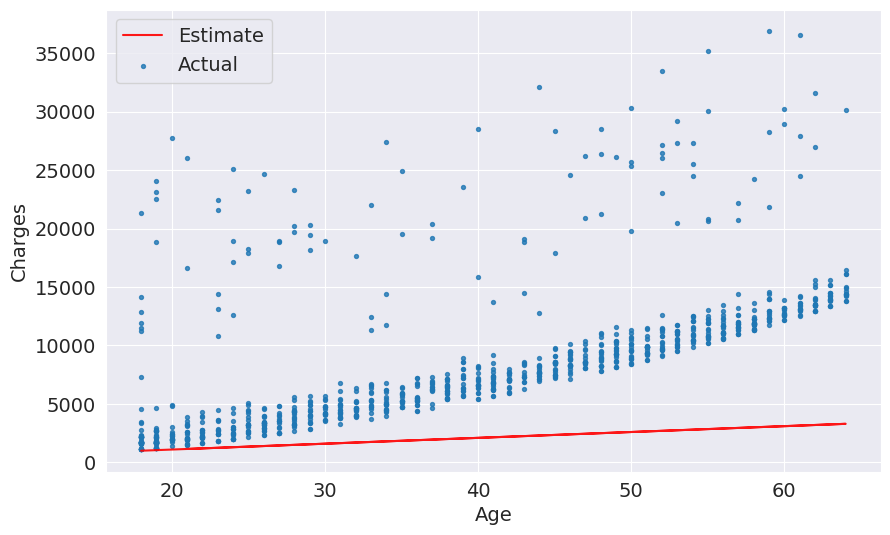

In [52]:
try_parameters(w, b)

In [53]:
targets = non_smoker_df['charges']
predicted = estimate_charges(non_smoker_df.age, w, b)

In [54]:
rmse(targets, predicted)

8461.949562575493

Veja como podemos interpretar o número acima:

`Em média, cada elemento na previsão difere da meta real em \$8461 .`

O resultado é chamado de perda porque `indica o quão ruim o modelo é na previsão das variáveis-alvo`.

 Representa perda de informação no modelo: quanto menor a perda, melhor é o modelo.

Vamos modificar as try_parametersfunções para exibir também a perda

In [55]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    predictions = estimate_charges(ages, w, b)

    plt.plot(ages, predictions, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Prediction', 'Actual']);

    loss = rmse(target, predictions)
    print("RMSE Loss: ", loss)

RMSE Loss:  8461.949562575493


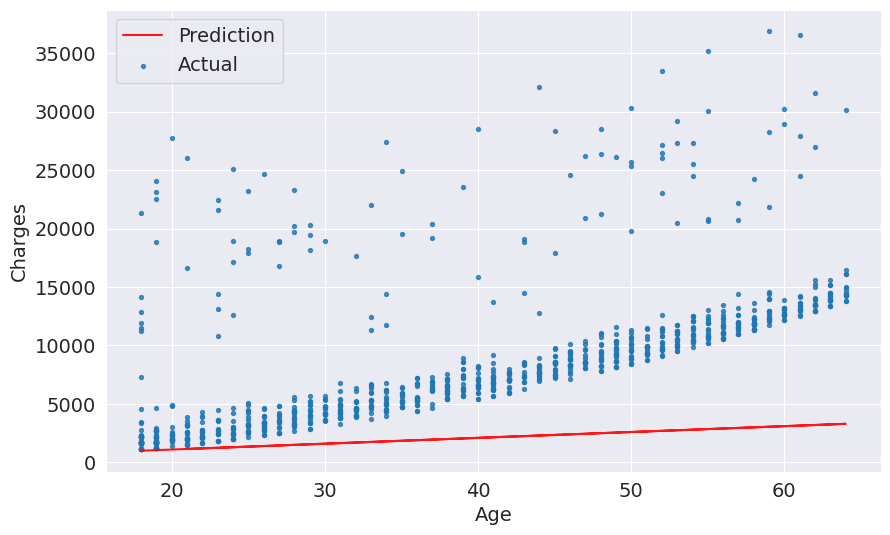

In [56]:
try_parameters(50, 100)

RMSE Loss:  4755.368599156885


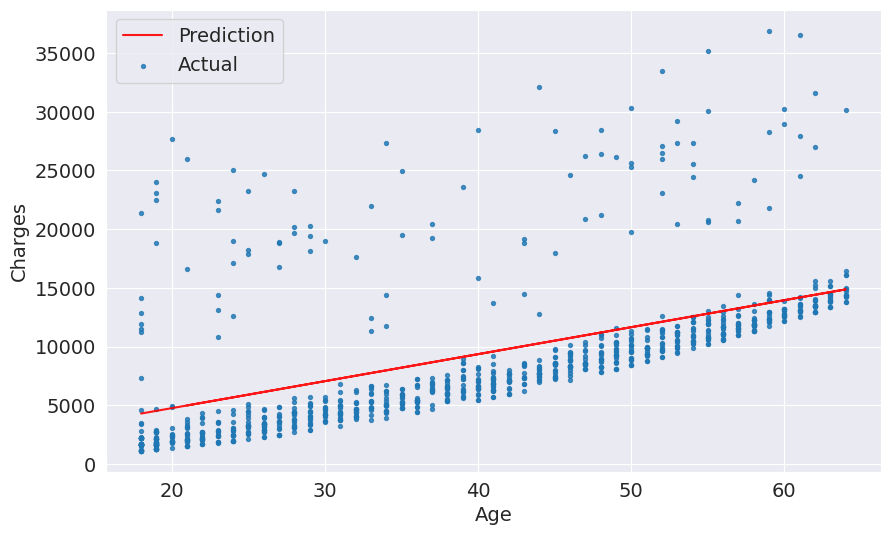

In [57]:
try_parameters(230,150)

#Otimizador
Em seguida, precisamos de uma estratégia para modificar os pesos we breduzir a perda e melhorar o “ajuste” da linha aos dados.

- minimos quadrados ordinarios

- descida gradiente estocastica

Ambos têm o mesmo objetivo:  `minimizar a perda, entretanto, enquanto os mínimos quadrados ordinários calculam diretamente os melhores valores we busam operações de matriz, enquanto a descida gradiente usa uma abordagem iterativa, começando com valores aleatórios we bmelhorando-os lentamente usando derivados`

#Regressão Linear usando Scikit-learn

Na prática, você nunca precisará implementar nenhum dos métodos acima. Você pode usar uma biblioteca scikit-learnpara fazer isso por você.

In [58]:
!pip install scikit-learn --quiet

Vamos usar a LinearRegressionclasse from scikit-learnpara encontrar a linha de melhor ajuste para "idade" versus "cargas" usando a técnica de otimização de mínimos quadrados ordinária.

In [59]:
from sklearn.linear_model import LinearRegression

In [60]:
model = LinearRegression()#novo objeto modelo

A seguir, podemos usar o fitmétodo do modelo para encontrar a linha de melhor ajuste para as entradas e metas.

Não que a entrada Xdeva ser um array 2-d, então precisaremos passar um dataframe, em vez de uma única coluna.

In [61]:
inputs = non_smoker_df[['age']]
targets = non_smoker_df.charges
print('inputs.shape :', inputs.shape)
print('targes.shape :', targets.shape)

inputs.shape : (1064, 1)
targes.shape : (1064,)


In [62]:
#Vamos ajustar o modelo aos dados.
model.fit(inputs, targets)

LinearRegression()

#Agora podemos fazer previsões usando o modelo.

`Vamos tentar prever as cobranças para as idades de 23, 37 e 61 anos`

In [63]:
model.predict(np.array([[23],
                        [37],
                        [61]]))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([ 4055.30443855,  7796.78921819, 14210.76312614])

Esses valores parecem razoáveis? Compare-os com o gráfico de dispersão acima.

Vamos calcular as previsões para todo o conjunto de entradas

In [64]:
predictions = model.predict(inputs)

In [65]:
predictions

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

In [66]:
#Vamos calcular a perda RMSE para avaliar o modelo.
rmse(targets, predictions)

4662.505766636395

Parece que nossa previsão está `errada em média em US$ 4.000, o que não é tão ruim considerando o fato de que existem vários valores discrepantes`

Os parâmetros do modelo são armazenados nas propriedades coef_e intercept_.

In [67]:
# w
model.coef_

array([267.24891283])

In [68]:
# b
model.intercept_

-2091.4205565650864

Esses parâmetros estão próximos de suas melhores estimativas?

Vamos visualizar a linha criada pelos parâmetros acima.

RMSE Loss:  4662.505766636395


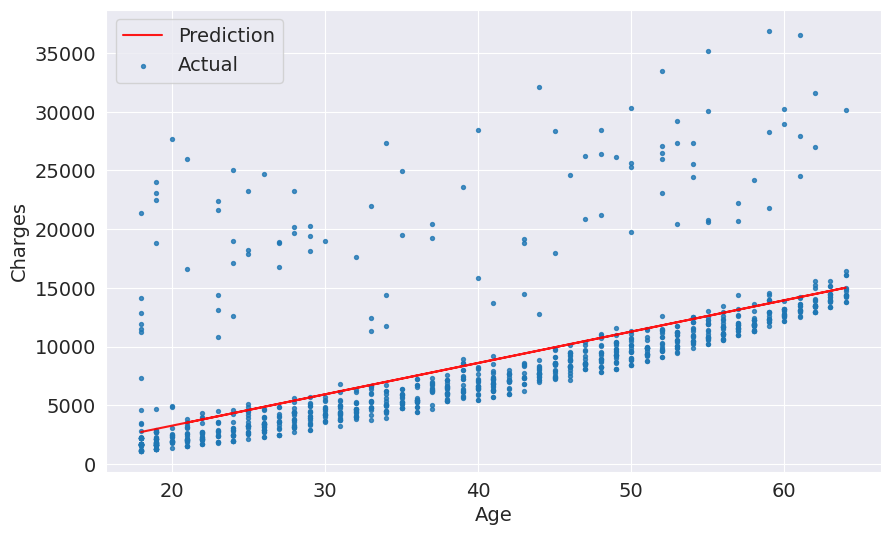

In [69]:
try_parameters(model.coef_, model.intercept_)

Na verdade, a linha está bastante próxima dos pontos. Está um pouco acima do agrupamento de pontos, porque também tenta levar em conta os valores discrepantes.

Use a `SGDRegressor` classe from scikit-learnpara treinar um modelo usando a técnica estocástica de gradiente descendente. Faça previsões e calcule a perda. Você vê alguma diferença no resultado?

In [70]:
from sklearn.linear_model import SGDRegressor

In [71]:
model = SGDRegressor()

In [72]:
inputs = non_smoker_df[['age']]
targets = non_smoker_df.charges
print('inputs.shape :', inputs.shape)
print('targes.shape :', targets.shape)

inputs.shape : (1064, 1)
targes.shape : (1064,)


In [73]:
model.fit(inputs, targets)

SGDRegressor()

In [74]:
model.predict(np.array([[23],
                        [37],
                        [61]]))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SGDRegressor was fitted with feature names



array([ 4599.10155782,  6871.92944201, 10768.20581489])

#DEU RESULTADOS DIFERENTES

In [75]:
predictions = model.predict(inputs)

In [76]:
predictions

array([3787.37731347, 5410.82580217, 6222.55004652, ..., 3787.37731347,
       3787.37731347, 4274.41186008])

In [77]:
rmse(targets, predictions)

5029.958231626336


ERRO PIOR QUE REGRESSAO LINEAR.

In [78]:
# w
model.coef_

array([162.34484887])

In [79]:
# b
model.intercept_

array([865.17003381])

RMSE Loss:  5029.958231626336


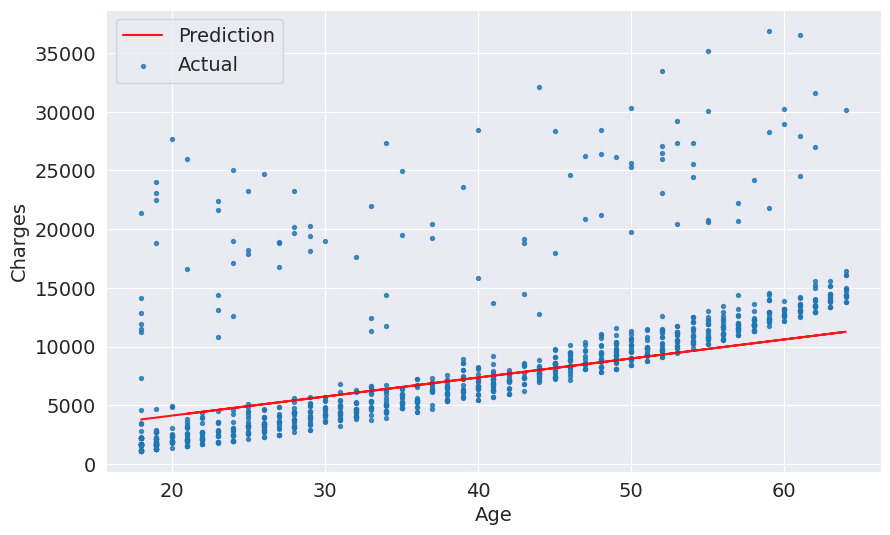

In [80]:
try_parameters(model.coef_, model.intercept_)

#REGRESSAO LINEAR PARA FUMANTES

In [81]:
smoker_df = medical_df[medical_df.smoker == 'yes']


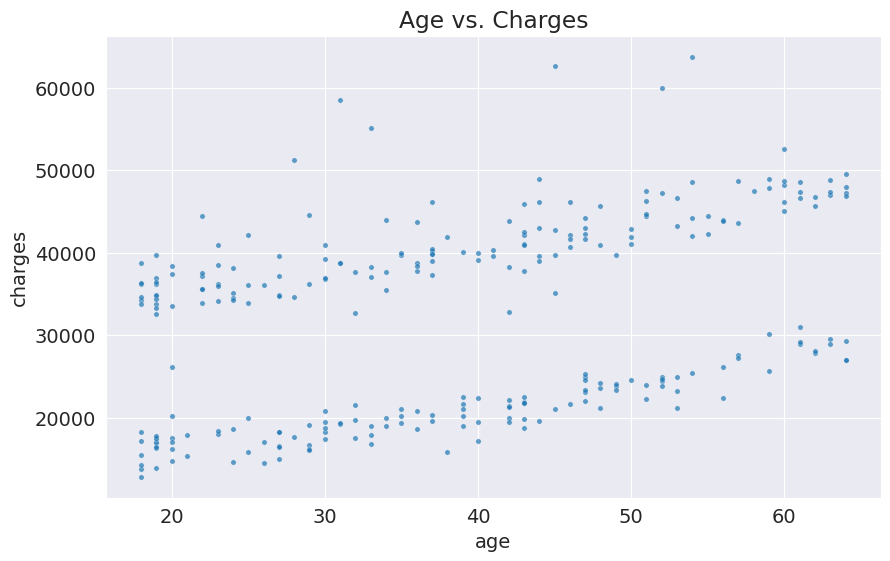

In [82]:
plt.title('Age vs. Charges')
sns.scatterplot(data=smoker_df, x='age', y='charges', alpha=0.7, s=15);

In [83]:
model = LinearRegression()

In [84]:
inputs = smoker_df[['age']]
targets = smoker_df.charges
print('inputs.shape :', inputs.shape)
print('targes.shape :', targets.shape)

inputs.shape : (274, 1)
targes.shape : (274,)


In [85]:
model.fit(inputs, targets)

LinearRegression()

In [86]:
model.predict(np.array([[23],
                        [37],
                        [61]]))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([27314.59297544, 31587.91940498, 38913.62185562])

In [87]:
predictions = model.predict(inputs)

In [88]:
predictions

array([26093.642567  , 39218.85945773, 28535.54338388, 29451.25619021,
       30672.20659865, 29756.49379232, 27009.35537333, 28840.78098599,
       30977.44420076, 38608.38425351, 31282.68180287, 34945.53302819,
       31282.68180287, 37997.90904929, 25788.40496489, 36471.72103874,
       26398.88016911, 28840.78098599, 28535.54338388, 27009.35537333,
       31587.91940498, 34029.82022186, 37692.67144718, 38303.1466514 ,
       39829.33466195, 37387.43384507, 31893.15700709, 38913.62185562,
       26398.88016911, 39524.09705984, 29146.0185881 , 33724.58261975,
       26093.642567  , 30061.73139443, 30672.20659865, 29451.25619021,
       34335.05782397, 33114.10741553, 34945.53302819, 25788.40496489,
       29451.25619021, 33114.10741553, 25788.40496489, 39524.09705984,
       31282.68180287, 28535.54338388, 30977.44420076, 26093.642567  ,
       33114.10741553, 32503.63221131, 26093.642567  , 27314.59297544,
       39524.09705984, 25788.40496489, 39524.09705984, 36776.95864085,
      

In [89]:
rmse(targets, predictions)

10711.00334810241

In [90]:
# w
model.coef_

array([305.23760211])

In [91]:
# b
model.intercept_

20294.128126915966

RMSE Loss:  24338.502872599212


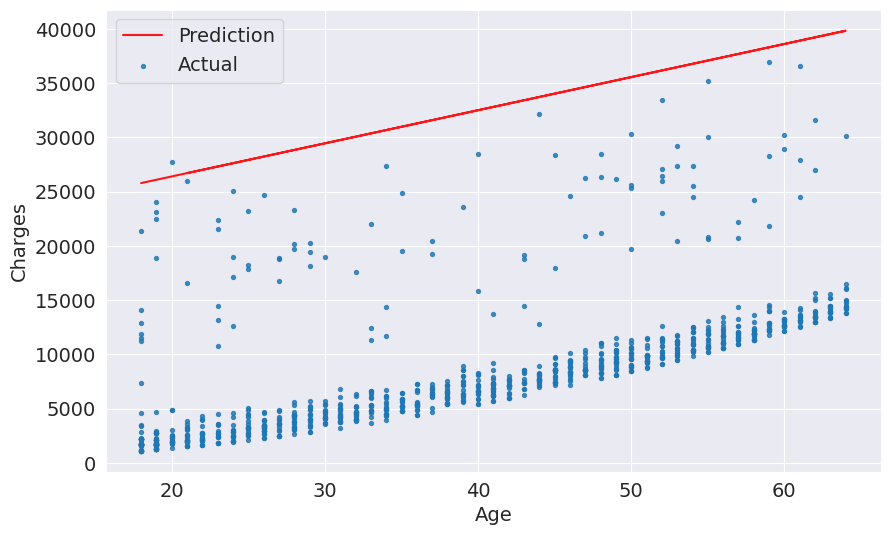

In [92]:
try_parameters(model.coef_, model.intercept_)

#Aprendizado de máquina
Parabéns, você acabou de treinar seu primeiro modelo de aprendizado de máquina! `O aprendizado de máquina é simplesmente o processo de calcular os melhores parâmetros para modelar o relacionamento entre alguns recursos e alvos`.

Todo problema de aprendizado de máquina tem três componentes:

1. Modelo

2. Função de Custo

3. Otimizador

Veremos vários exemplos de cada um dos itens acima em tutoriais futuros. Veja como a relação entre esses três componentes pode ser visualizada:



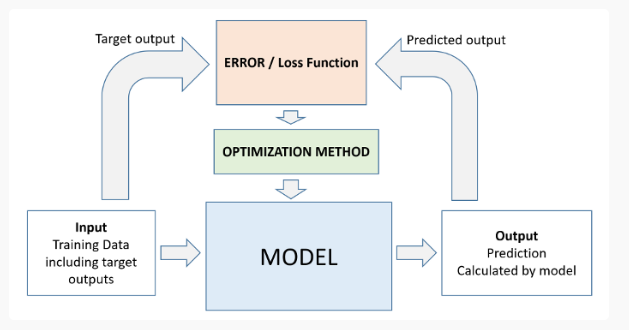

Como vimos acima, são necessárias apenas algumas linhas de código para treinar um modelo de aprendizado de máquina usando o scikit-learn

In [93]:
# Cria inputs and targets
inputs, targets = non_smoker_df[['age']], non_smoker_df['charges']

# Cria and train the model
model = LinearRegression().fit(inputs, targets)

# Gera predições
predictions = model.predict(inputs)

# Computa a perda para avaliar o model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.505766636395


#FUMANTES


In [94]:
#cria um dataframe a ser observado
smoker_df = medical_df[medical_df.smoker == 'yes']
# Cria inputs and targets
inputs, targets = smoker_df[['age']], smoker_df['charges']

# Cria and train the model
model = LinearRegression().fit(inputs, targets)

# Gera predições
predictions = model.predict(inputs)

# Computa a perda para avaliar o model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 10711.00334810241


#MULHERES

In [95]:
#cria um dataframe a ser observado
female_df = medical_df[medical_df.sex == 'female']
# Cria inputs and targets
inputs, targets = female_df[['age']], female_df['charges']

# Cria and train the model
model = LinearRegression().fit(inputs, targets)

# Gera predições
predictions = model.predict(inputs)

# Computa a perda para avaliar o model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 10518.242871415781


#HOMENS

In [96]:
#cria um dataframe a ser observado
male_df = medical_df[medical_df.sex == 'male']
# Cria inputs and targets
inputs, targets = male_df[['age']], male_df['charges']

# Cria and train the model
model = LinearRegression().fit(inputs, targets)

# Gera predições
predictions = model.predict(inputs)

# Computa a perda para avaliar o model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 12433.976109849502


#Regressão Linear usando Vários Recursos

Até agora, usamos o recurso “idade” para estimar “cobranças”. Adicionar outro recurso como “bmi” é bastante simples. Simplesmente assumimos a seguinte relação:

Precisamos alterar apenas uma linha de código para incluir o IMC.

In [97]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age', 'bmi']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.3128354612945


Como você pode ver, `somar o IMC não parece reduzir muito a perda`, pois o IMC tem uma correlação muito fraca com as cobranças, principalmente para não fumantes.

In [98]:
non_smoker_df.charges.corr(non_smoker_df.bmi)

0.0840365431283327

In [99]:
fig = px.scatter(non_smoker_df, x='bmi', y='charges', title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

Também podemos visualizar a relação entre todas as 3 variáveis ​​“idade”, “IMC” e “cargas” usando um gráfico de dispersão 3D.

In [100]:
fig = px.scatter_3d(non_smoker_df, x='age', y='bmi', z='charges')
fig.update_traces(marker_size=3, marker_opacity=0.5)
fig.show()

Você pode ver que é mais difícil interpretar um gráfico de dispersão 3D em comparação com um gráfico de dispersão 2D. À medida que adicionamos mais recursos, torna-se impossível visualizar todos os recursos de uma vez, por isso usamos medidas como correlação e perda.

Vamos também verificar os parâmetros do modelo.

In [101]:
model.coef_, model.intercept_

(array([266.87657817,   7.07547666]), -2293.6320906488727)

`Claramente, o IMC tem um peso muito menor e você pode ver por quê`. Tem uma pequena contribuição, e mesmo isso é provavelmente acidental. É importante ter isso em mente: `você não consegue encontrar um relacionamento que não existe, não importa qual técnica de aprendizado de máquina ou algoritmo de otimização você aplique.`

In [102]:
# Create inputs and targets
inputs, targets = non_smoker_df[['bmi']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 5969.772531913293


Claramente pior.

Vamos dar um passo adiante e adicionar a coluna numérica final:` “crianças”`, que parece ter alguma correlação com “cobranças”.

In [103]:
non_smoker_df.charges.corr(non_smoker_df.children)

0.13892870453542192

In [104]:
fig = px.strip(non_smoker_df, x='children', y='charges', title= "Children vs. Charges")
fig.update_traces(marker_size=4, marker_opacity=0.7)
fig.show()

In [105]:
# Cria inputs and targets
inputs, targets = non_smoker_df[['age', 'bmi', 'children']], non_smoker_df['charges']

# criar modelo e treinar.
model = LinearRegression().fit(inputs, targets)

#Gerar predições
predictions = model.predict(inputs)

# Computar a perda para avaliar o modelo
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4608.470405038247


Mais uma vez, não vemos uma grande redução na perda, embora seja maior do que no caso do IMC.

EXERCÍCIO : Repita as etapas desta seção para treinar um modelo de regressão linear para estimar despesas médicas para fumantes. Visualize as metas e previsões e calcule a perda.

#FUMANTES

In [106]:
# Cria inputs and targets
inputs, targets = smoker_df[['age', 'bmi', 'children']], smoker_df['charges']

# criar modelo e treinar.
model = LinearRegression().fit(inputs, targets)

#Gerar predições
predictions = model.predict(inputs)

# Computar a perda para avaliar o modelo
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 5718.202480524154


A PERDA DIMINIU USANDO AS VARIAVEIS BMI E CHILDREN


Repita as etapas desta seção para treinar um modelo de regressão linear para estimar despesas médicas para todos os clientes. Visualize as metas e previsões e calcule a perda. A perda é menor ou maior?

#PARA TODO CONJUNTO DE DADOS

In [107]:
# Cria inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children']], medical_df['charges']

# criar modelo e treinar.
model = LinearRegression().fit(inputs, targets)

#Gerar predições
predictions = model.predict(inputs)

# Computar a perda para avaliar o modelo
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 11355.317901125973


#Usando recursos categóricos para aprendizado de máquina


Até agora usamos apenas colunas numéricas, pois só podemos realizar cálculos com números.

`Se pudéssemos usar colunas categóricas como “fumante”, poderíamos treinar um único modelo para todo o conjunto de dados.`

Para usar as colunas categóricas, precisamos simplesmente convertê-las em números. Existem três técnicas comuns para fazer isso:

Se uma coluna categórica tiver apenas duas categorias (é chamada de `categoria binária`), podemos substituir seus valores por 0 e 1.

Se uma coluna categórica tiver `mais de 2 categorias, podemos realizar a
codificação one-hot`, ou seja, criar uma nova coluna para cada categoria com 1s e 0s.


Se as categorias tiverem uma ordem natural (por exemplo, frio, neutro, quente, fervente), então elas poderão ser convertidas em números `(por exemplo, 1, 2, 3, 4)` preservando a ordem. Eles são chamados de `ordinais`.

#Categorias Binárias

A categoria “fumante” possui apenas dois valores “sim” e “não”. Vamos criar uma nova coluna “smoker_code” contendo 0 para “não” e 1 para “sim”

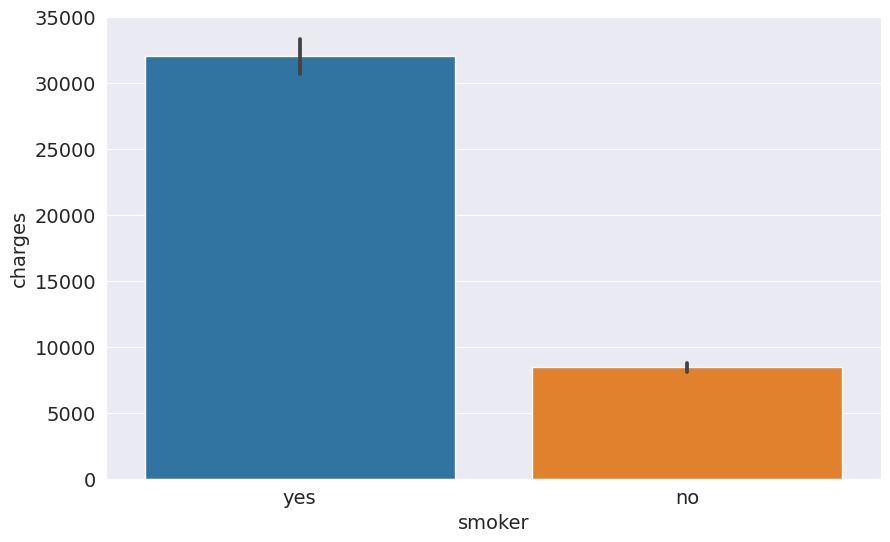

In [108]:
sns.barplot(data=medical_df, x='smoker', y='charges');

In [109]:
smoker_codes = {'no': 0, 'yes': 1}
medical_df['smoker_code'] = medical_df.smoker.map(smoker_codes)

In [110]:
medical_df.charges.corr(medical_df.smoker_code)

0.787251430498478

In [111]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0
1334,18,female,31.920,0,no,northeast,2205.98080,0
1335,18,female,36.850,0,no,southeast,1629.83350,0
1336,21,female,25.800,0,no,southwest,2007.94500,0


In [112]:
# Create inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children', 'smoker_code']], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6056.439217188081


Erro anterior:11355.317901125973

A perda reduz de 11355 para 6056 quase 50%!

Esta é uma lição importante: nunca ignore dados categóricos.

Vamos tentar adicionar a coluna “sexo” também.

<Axes: xlabel='sex', ylabel='charges'>

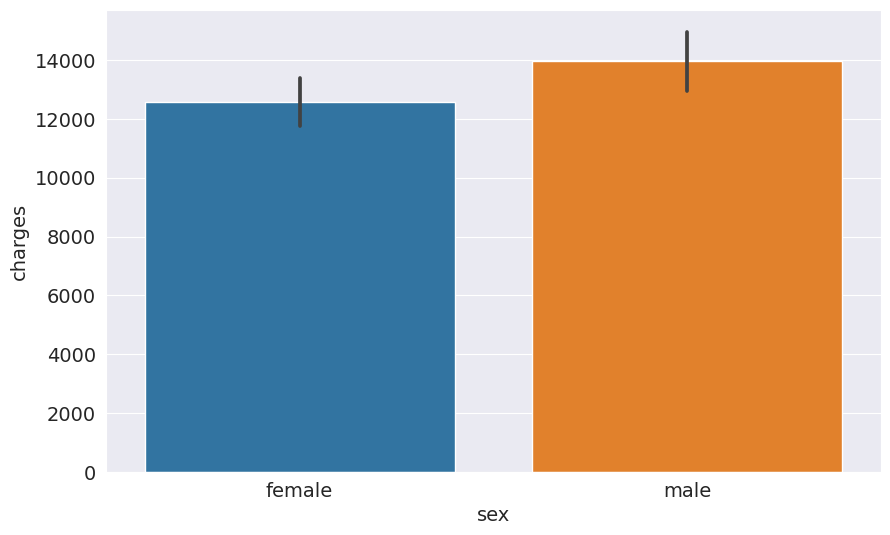

In [113]:
sns.barplot(data=medical_df, x='sex', y='charges')

In [114]:
sex_codes = {'female': 0, 'male': 1}

In [115]:
medical_df['sex_code'] = medical_df.sex.map(sex_codes)

In [116]:
medical_df.charges.corr(medical_df.sex_code)

0.057292062202025484

In [117]:
# Create inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children', 'smoker_code', 'sex_code']], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6056.100708754546


Como seria de esperar, isso tem um impacto significativo na perda.

#Codificação one-hot
A coluna “região” contém 4 valores, então precisaremos usar codificação dinâmica e criar uma nova coluna para cada região.

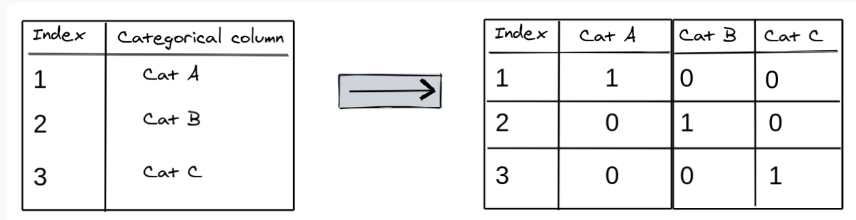

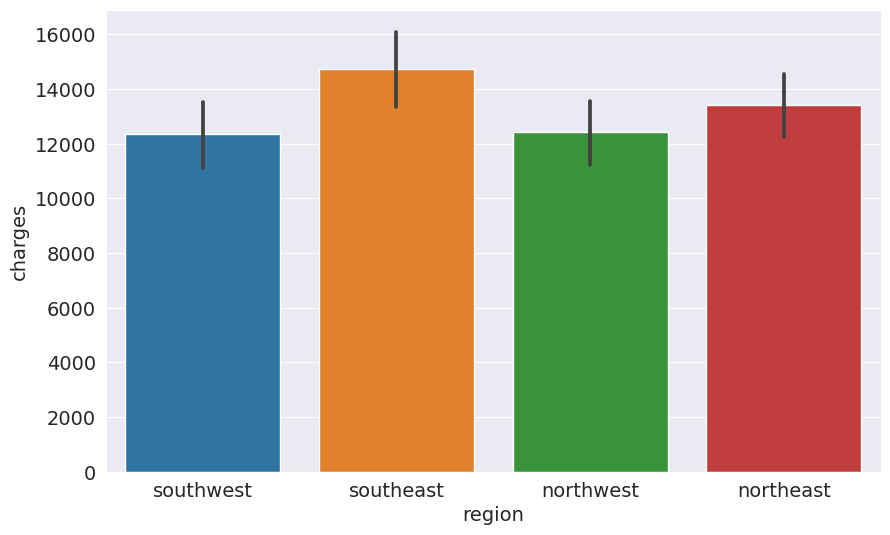

In [118]:
sns.barplot(data=medical_df, x='region', y='charges');

In [119]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(medical_df[['region']])
enc.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [120]:
one_hot = enc.transform(medical_df[['region']]).toarray()
one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [121]:
medical_df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot

In [122]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0.0,0.0,0.0,1.0



Vamos incluir as colunas da região em nosso modelo de regressão linear

In [123]:
# Create inputs and targets
input_cols = ['age', 'bmi', 'children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = medical_df[input_cols], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.6796511744515


Mais uma vez, isto leva a uma redução bastante pequena na perda.

#EXERCÍCIO :

Dois modelos de regressão linear separados, um para fumantes e outro para não fumantes, são melhores do que um único modelo de regressão linear? Por que ou por que não? Experimente e veja se você consegue justificar sua resposta com dados.

#FUMANTES

In [124]:
#Cria um dataframe
#cria um dataframe a ser observado
smoker_df = medical_df[medical_df.smoker_code == 1]
# Create inputs and targets
input_cols = ['age', 'bmi', 'children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = smoker_df[input_cols], smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 5668.4678821121515


#NÃO FUMANTES

In [125]:
#cria um dataframe a ser observado
no_smoker_df = medical_df[medical_df.smoker_code == 0]
# Create inputs and targets
input_cols = ['age', 'bmi', 'children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = no_smoker_df[input_cols], no_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4573.074988795492


#separar melhor ambas as predições de grupos

#Dimensionamento de recursos

Lembre-se de que, devido a requisitos regulatórios, também precisamos explicar a lógica por trás das previsões do nosso modelo.

Para `comparar a importância de cada característica no modelo`, nosso primeiro instinto pode ser `comparar seus pesos`.

In [126]:
model.coef_ #w

array([ 2.64481438e+02,  1.89804618e+01,  5.87458257e+02, -2.84217094e-14,
       -5.25970487e+02,  7.33683019e+02,  1.85554256e+02, -2.58365372e+02,
       -6.60871903e+02])

In [127]:
model.intercept_ #b

-2940.747154556304

In [128]:
weights_df = pd.DataFrame({
    'feature': np.append(input_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df

,feature,weight
0,age,2.644814e+02
1,bmi,1.898046e+01
2,children,5.874583e+02
3,smoker_code,-2.842171e-14
4,sex_code,-5.259705e+02
5,northeast,7.336830e+02
6,northwest,1.855543e+02
7,southeast,-2.583654e+02
8,southwest,-6.608719e+02
9,1,-2.940747e+03


Embora pareça que o IMC e o “Nordeste” têm peso maior que a idade, lembre-se que a faixa de valores do IMC é limitada (15 a 40) e a coluna “Nordeste” assume apenas os valores 0 e 1.

Como colunas diferentes têm intervalos diferentes, nos deparamos com dois problemas:

#Não podemos comparar os pesos de colunas diferentes para identificar quais recursos são importantes


Uma coluna com uma gama maior de entradas pode afetar desproporcionalmente a perda e dominar o processo de otimização.

Por esse motivo, `é prática comum dimensionar (ou padronizar) os valores na coluna #numérica
subtraindo a média e dividindo pelo desvio padrão.`

Podemos aplicar o dimensionamento usando a classe StandardScaler do scikit-learn.

In [129]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0.0,0.0,0.0,1.0


In [130]:
from sklearn.preprocessing import StandardScaler

In [131]:
numeric_cols = ['age', 'bmi', 'children']
scaler = StandardScaler()
scaler.fit(medical_df[numeric_cols])

StandardScaler()

In [132]:
scaler.mean_

array([39.20702541, 30.66339686,  1.09491779])

In [133]:
scaler.var_

array([197.25385199,  37.16008997,   1.45212664])

In [134]:
scaled_inputs = scaler.transform(medical_df[numeric_cols])
scaled_inputs

array([[-1.43876426, -0.45332   , -0.90861367],
       [-1.50996545,  0.5096211 , -0.07876719],
       [-0.79795355,  0.38330685,  1.58092576],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367],
       [-1.29636188, -0.79781341, -0.90861367],
       [ 1.55168573, -0.26138796, -0.90861367]])

Agora podemos combiná-los com os dados categóricos

In [135]:
cat_cols = ['smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
categorical_data = medical_df[cat_cols].values

In [136]:
inputs = np.concatenate((scaled_inputs, categorical_data), axis=1)
targets = medical_df.charges

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.6796511744515


Agora podemos comparar os pesos na fórmula:

In [137]:
weights_df = pd.DataFrame({
    'feature': np.append(numeric_cols + cat_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df.sort_values('weight', ascending=False)

,feature,weight
3,smoker_code,23848.534542
9,1,8466.483215
0,age,3607.472736
1,bmi,2067.691966
5,northeast,587.009235
2,children,572.998210
6,northwest,234.045336
4,sex_code,-131.314359
8,southwest,-373.041756
7,southeast,-448.012814


- positivos = adiciona mais gastos em dolar a cada ponto
- negativos = menos gastos em dolar

por ex., a cada avanço da idade aumentar os gastos em 3600$

- e ter criança aumenta 572 a cada criança.

- ser homem tambem tem menos gastos no convenio.

#O valor 1 simplesmente representa a interceptação.



#testando

Quando uma nova pessoa vier até você, você terá que dimensionar esses valores antes de poder colocá-los no modelo.

Para novos clientes, p.ex:

`Entao a primeira coisa que queremos fazer é fazer escalar e colocar diretamente os valores respectivos abaixo para cada feature, anteriormente, dada ao modelo`.

In [138]:
new_customers = ([28,30,2,1,0,0,1,0,0.])# primeiro vc pega os valores
#reais em um cliente

In [139]:
scaler.transform([[28,30,2]]) #faz o escalar das tres
#primeiras features que são numericas. copia a saida, para
#criar nossa predição e depois cola as
#variaveis categoricas, junto ao retorno do scaler.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



array([[-0.79795355, -0.10882659,  0.75107928]])

In [141]:
model.predict([[-0.79795355, -0.10882659,  0.75107928,1,0,0,1,0,0.]])

array([29875.81463371])

Como você pode ver agora, os recursos mais importantes são:

- Fumante
- Idade
- IMC

#Criando um conjunto de testes

Modelos como o que criamos neste tutorial foram projetados para serem usados ​​no `mundo real` . É prática comum reservar uma pequena fração dos dados (por exemplo, 10%) apenas `para testar e reportar os resultados do modelo`.

In [140]:
from sklearn.model_selection import train_test_split

In [142]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.1)

In [143]:
# Create and train the model
model = LinearRegression().fit(inputs_train, targets_train)

# Generate predictions
predictions_test = model.predict(inputs_test)

# Compute loss to evalute the model
loss = rmse(targets_test, predictions_test)
print('Test Loss:', loss)

Test Loss: 5791.962609472319


Vamos comparar isso com a perda de treinamento.

In [144]:
# Generate predictions
predictions_train = model.predict(inputs_train)

# Compute loss to evalute the model
loss = rmse(targets_train, predictions_train)
print('Training Loss:', loss)

Training Loss: 6071.066412900081


#Como abordar um problema de aprendizado de máquina

`Aqui está uma estratégia que você pode aplicar para abordar qualquer problema de aprendizado de máquina:`

- Explore os dados e encontre correlações entre entradas e metas
- Escolha o modelo certo, funções de perda e otimizador para o problema em questão
- `Dimensionar variáveis ​​numéricas e codificar dados categóricos one-hot`
- Separe um conjunto de teste (usando uma fração do conjunto de treinamento)
- Treine o modelo
- Faça previsões no conjunto de testes e calcule a perda